## Notebook to generate synthetic data for clustering experiment
we will do experiment on:

1. High dimensional gaussian balls (synthetic dataset generated by sampling from hyper gaussian ball)
2. Combinations of dimension number and various types of distribution, mixed distribution. (this is to test applicablity on non-Gaussian dist)
3. Real use case dataset: UCI cloud data. (to test generalization to real life use cases)

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import pickle
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches

from sklearn.cluster import KMeans
from random import gauss
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from PIL import Image

In [20]:
def eucl_dist(a, b, axis=1):
    return np.linalg.norm(a - b, axis=axis)

def get_1d_projection(x,dim_out=1,scaling=True):
    '''
    input: 
    x: original data, in np array
    dim_out: dimension of projected dataset,default is 1
    scaling: kept as true, scale x before pca
    '''
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=dim_out)
    principalComponents = pca.fit_transform(x)

    return principalComponents

def get_best_1d(x):
    '''
    get best point from 1d projection of dataset
    output: the original point in dataset x (before pca), maybe multiple points qualified
    due to precision isclose, we then randomly pick from the best point set
    '''
    x_1d = get_1d_projection(x)
    x_median = np.mean(x_1d)
    
    '''
    best_pts = []
    for each in x_1d:
        #test if it's close to median value
        temp = np.isclose(each, x_median, rtol=1e-01, atol=1e-01, equal_nan=False)
        if temp:
            best_pt_ind = np.where(x_1d == each)
            #strip away brackets of np array and find best_pt from original x
            best_pt = x[best_pt_ind[0][0]]
            best_pts.append(best_pt)
    
    '''
    min_val = sum([x_1d[0]-a for a in x_1d])
    min_point = x_1d[0]
    for each in x_1d:
        distances = sum([math.pow((each-a),2) for a in x_1d])
        if distances <= min_val:
            min_val = distances
            min_point = each
    
    best_pt_ind = np.where(x_1d == min_point)
    best_pt = x[best_pt_ind[0][0]]
    
    #random pick one from best points 
    return best_pt

def get_center(k, X, first_pt_process = True):
    '''
    added a choice to choose first point more intelligently
    added control of this functionality
    '''
    temp = []
    if first_pt_process:
        #first center is appended here
        first_pt = get_best_1d(X)
        temp.append(first_pt)
    else:
        #original uniform random:
        temp.append(X[np.random.randint(0, len(X))])
    
    while len(temp)<k:
        d2 = np.array([min([np.square(eucl_dist(i,c, None)) for c in temp]) for i in X])
        prob = d2/d2.sum()
        cum_prob = prob.cumsum()
        r = np.random.random()
        ind = np.where(cum_prob >= r)[0][0]
        temp.append(X[ind])
    return np.array(temp)

def k_mean_pp(x, k,first_pt_process=True):
    # error = {key:0.0 for key in range(2,11)}
    # initalizing cluster variable
    center = get_center(k, x,first_pt_process)
    # for k in range(2,11):
    # assigining zeros to old centroids value
    center_old = np.zeros(center.shape)
    # initial error
    err = eucl_dist(center, center_old, None)

    cluster = {}
    
    while err != 0:
        # calculatin distance of data points from centroids and assiging min distance cluster centroid as data point cluster
        for i in range(len(x)):
            distances = eucl_dist(x[i], center)
            clust = np.argmin(distances)
            cluster[i] = clust
        # changing old centroids value
        center_old = np.copy(center)

        # Finding the new centroids by taking the average value
        for i in range(k):
            points = [x[j] for j in range(len(x)) if cluster[j] == i]
            if points:
                center[i] = np.mean(points, axis=0)

        # calculation difference between new centroid and old centroid values
        err = eucl_dist(center, center_old, None)

    # calculation total difference between cluster centroids and cluster data points
    error = 0
    for i in range(k):
        d = [eucl_dist(x[j], center[i], None) for j in range(len(x)) if cluster[j] == i]
        error += np.sum(d)

    # counting data points in all clusters
    count = {key: 0.0 for key in range(k)}
    for i in range(len(x)):
        count[cluster[i]] += 1

    # displaying cluster number, average distance between centroids and data points and cluster count
    # print(k, error / len(x), count)

    return cluster, error

def auto_test(x,test_rounds,k):
    '''
    test function comparing kmeans++ 
    with modified first point selection
    test_rounds: rounds to test, per point error is used to compare
    k is cluster number to try
    '''
    use_pca_costs = []
    no_pca_costs = []

    for i in range(test_rounds):
        if i%10 == 1:
            print('Round: %d/%d'%(i,test_rounds))
        res_1,per_pt_cost_1 = k_mean_pp(x,k)
        use_pca_costs.append(per_pt_cost_1)
        
        res_2,per_pt_cost_2 = k_mean_pp(x,k,False)
        no_pca_costs.append(per_pt_cost_2)

    pca_avg_cost = np.mean(np.array(use_pca_costs))
    no_pca_avg_cost = np.mean(np.array(no_pca_costs))
    print('average per point cost: with pca, random first point')
    print(pca_avg_cost,no_pca_avg_cost)
    return pca_avg_cost,no_pca_avg_cost

def manual_random_selection(x,k):
    '''
    x: data of row x feature
    k: number of centers randomly chosen
    output: k x feature ndarray for kmeans init param
    '''
    pool = list(range(x.shape[0]))
    res = []
    for i in range(k):
        ind = random.choice(pool)
        res.append(x[ind])
        pool.remove(ind)
    res_arr = np.array(res)
    return res_arr

def kmeans_customized(df,data_name):
    '''
    auto clustering tool
    input: df
    data_name:name of dataset
    '''
    wcss_original = []
    wcss_pp = []
    wcss_pp_mod = []
    wcss_pp_mod2 = []


    data_in = df.values
    
    data_in = StandardScaler().fit_transform(data_in)
    
    for i in range(2, 11):
        '''
        kmeans = KMeans(n_clusters=i, init=manual_random_selection(data_in,i), max_iter=3, n_init=10, random_state=0)
        kmeans.fit(data_in)
        wcss_original.append(kmeans.inertia_)

        kmeans_pp = KMeans(n_clusters=i, init='k-means++', max_iter=3, n_init=10, random_state=0)
        kmeans_pp.fit(data_in)
        wcss_pp.append(kmeans_pp.inertia_)
        '''
        
        a,cost = k_mean_pp(data_in,i,first_pt_process=True)
        b,cost2 = k_mean_pp(data_in,i,first_pt_process=False)


        wcss_pp_mod.append(cost)
        wcss_pp_mod2.append(cost2)
        
    #plt.plot(range(2, 11), wcss_pp,color = 'r')
    #plt.plot(range(2, 11), wcss_original,color = 'g')
    plt.plot(range(2, 11), wcss_pp_mod,color = 'r')
    plt.plot(range(2, 11), wcss_pp_mod2,color = 'g')

    red_patch = mpatches.Patch(color='red', label='kmeans++, modified')
    green_patch = mpatches.Patch(color='green', label='kmeans++')

    plt.legend(handles=[red_patch,green_patch])

    plt.title('Elbow Chart, %s data'%data_name)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    return None

### Data generation

In [21]:
#type 1: synthetic Gaussian Balls Distribution
def gaussian_ball_sampler(num_points,features,clusters_count,std_range):
    '''
    std_range is a given range to generate random std for each feature
    num_points is total number of data rows to generate, features is number of features to generate
    '''
    # Make features and targets with number of samples
    std_list = []
    
    for i in range(clusters_count):
        rand_std = gauss(std_range[0],std_range[1])
        std_list.append(rand_std)
    
    features, target = make_blobs(n_samples = num_points,
                      n_features = features,
                      centers = clusters_count,
                      cluster_std = std_list,
                      shuffle = True)
    
    gaussian_balls = pd.DataFrame(data=features)
    columns_count = gaussian_balls.shape[1]
    cols = []
    #create column names
    for col in range(columns_count):
        str_col_nm = 'gaussian_col_%s'%col
        cols.append(str_col_nm)

    gaussian_balls.columns = cols

    return gaussian_balls,target

#second part: sampled from Gamma
def gamma_sampler(shape,scale,num_samples):
    '''
    generate ndarray sampled from gamma distribution, one column at each call
    '''
    data_array = np.random.gamma(shape, scale, num_samples)
    count, bins, ignored = plt.hist(data_array, 50, density=True)
    return data_array

def mixed_data_maker(num_gamma_cols):
    #gaussian part:
    #using global vars to get pd df
    gaussian_table,label = gaussian_ball_sampler(num_points,features,clusters_count,std_range)
    print('gamma cols need normalization to align with gaussian columns')
    for i in range(num_gamma_cols):
        print('creating gamma col %d'%i)
        gamma_col = gamma_sampler(shape,scale,num_points)
        gaussian_table['gamma_col_%s'%i] = pd.Series(gamma_col)
    print('final mixed table shape:',gaussian_table.shape)
    return gaussian_table

### Type 1 dataset: synthetic from gaussian distributions

In [22]:
#to sample from gaussian balls
num_points = 2000
features = 15
clusters_count = 5
std_range = [2,0.5]

In [23]:
gaussian_table,label = gaussian_ball_sampler(num_points,features,clusters_count,std_range)

### Type 2 dataset: some synthetic gaussian, some synthetic gamma, mixed data

In [24]:
#first part: sampled from Gaussian
#to sample from gaussian balls
num_points = 2000
gaussian_features = 10
clusters_count = 5
std_range = [2,0.5]
#to sample from gamma distribution
shape,scale = 3,10
num_gamma_cols = 3

gamma cols need normalization to align with gaussian columns
creating gamma col 0
creating gamma col 1
final mixed table shape: (2000, 17)


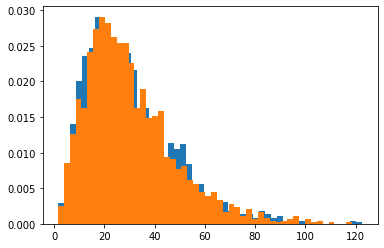

In [25]:
mixed_dataset = mixed_data_maker(2)

### Type 3 dataset: Real use cases dataset for clustering: UCI cloud

In [16]:
#UCI cloud dataset, with 10 dimensions

with open('cloud.data') as input_file:
    lines = input_file.readlines()
    newLines = []
    
    for line in lines:
        list_line = line.strip().split(" ")
        while("" in list_line) : 
            list_line.remove("")
        num_list = [float(a) for a in list_line]
        newLines.append(num_list)
        
UCI_cloud = pd.DataFrame.from_records(newLines)

columns_count = UCI_cloud.shape[1]

cols = []
#create column names
for col in range(columns_count):
    str_col_nm = 'attr_%s'%col
    cols.append(str_col_nm)

UCI_cloud.columns = cols
#UCI_cloud.to_csv("UCI_cloud.csv")

### Experiment: Kmeans++ versus Kmeans++ modified

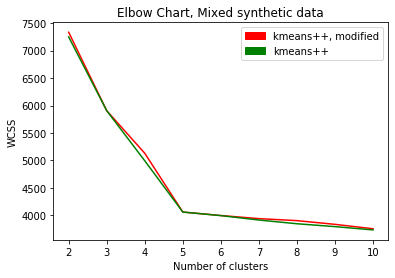

In [26]:
kmeans_customized(mixed_dataset,'Mixed synthetic')

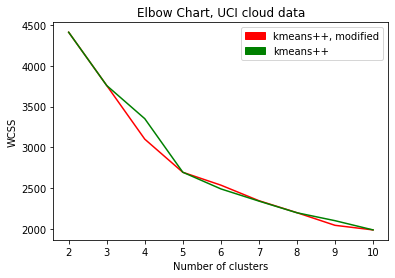

In [27]:
kmeans_customized(UCI_cloud,'UCI cloud')

### Next proposed method (idea, how to find dense region by sampling)

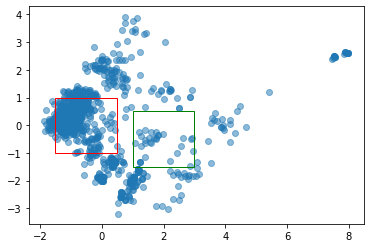

In [28]:
# loading dataset of form [[data1],[data2], ....]
inp = pickle.load(open('test.pickle', 'rb'))
x = np.array([i[0] for i in inp])

x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)


# Create figure and axes
fig,ax = plt.subplots(1)

plt.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.5)

# Create a Rectangle patch
rect1 = patches.Rectangle((-1.5,-1),2,2,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((1,-1.5),2,2,linewidth=1,edgecolor='g',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()